<a href="https://www.kaggle.com/code/elarsaks/finnish-tech-salary-survey-2024-analytics" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
## 1. Problem Definition

### Target Variable (What do we want to predict?)
**`monthly_salary_eur`** - The monthly gross salary in euros.

This is a **regression problem** since we are predicting a continuous numerical value (salary amount).

### Features (What information do we use for prediction?)
We will use the following features to predict salary:

| Feature | Description | Type |
|---------|-------------|------|
| `source_language` | Survey language (fi/en) | Categorical |
| `age` | Age group of the respondent | Categorical |
| `gender` | Gender of the respondent | Categorical |
| `experience_years` | Years of professional experience | Numerical |
| `company_type` | Type of company (consulting, product, etc.) | Categorical |
| `role_group` | Grouped job role category | Categorical |
| `education_level` | Highest education level achieved | Categorical |
| `location_category` | Work location (capital region vs rest of Finland) | Categorical |
| `office_time_percent` | Percentage of time spent in office | Numerical |

### Why these features?
- **Experience and education** are traditional salary predictors
- **Location** reflects cost-of-living differences
- **Company type and role** capture compensation structures
- **Survey language, age, gender** help detect potential reporting or distributional differences in the data

---
## 2. Collect & Load Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
from datetime import datetime
import joblib
import json
import os

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Detect if running on Kaggle
IS_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

# Set input/output directories based on environment
if IS_KAGGLE:
    # Use the data cleaning notebook as the data source
    DATA_DIR = Path("/kaggle/input/finnish-tech-salary-survey-2024-data-cleaning")
    MODEL_DIR = Path("/kaggle/working")
    print("Running on Kaggle - data will be read from cleaning notebook output")
    print("Running on Kaggle - models will be saved to /kaggle/working")
else:
    DATA_DIR = Path("processed")
    MODEL_DIR = Path("models")
    # Create models directory if it doesn't exist
    MODEL_DIR.mkdir(exist_ok=True)
    print(f"Running locally - data will be read from '{DATA_DIR}/'")
    print(f"Running locally - models will be saved to '{MODEL_DIR}/'")

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")


Running on Kaggle - data will be read from cleaning notebook output
Running on Kaggle - models will be saved to /kaggle/working
Libraries imported successfully!


In [2]:
# Load the cleaned dataset
df = pd.read_csv(DATA_DIR / 'koodiklinikka_salary_survey_2024_cleaned.csv')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")


Dataset loaded: 539 rows, 19 columns

Columns: ['source_language', 'age', 'gender', 'experience_years', 'monthly_salary_eur', 'annual_income_eur', 'income_change_pct', 'company', 'company_type', 'role', 'role_en', 'role_group', 'education', 'education_en', 'education_level', 'office_city', 'location_category', 'office_time_percent', 'salary_competitive']


---
## 3. Data Exploration

In [3]:
# Display first few rows
print("=" * 60)
print("FIRST 5 ROWS OF DATA")
print("=" * 60)
df.head()


FIRST 5 ROWS OF DATA


,source_language,age,gender,experience_years,monthly_salary_eur,annual_income_eur,income_change_pct,company,company_type,role,role_en,role_group,education,education_en,education_level,office_city,location_category,office_time_percent,salary_competitive
0,fi,46-50,male,27.0,7250.0,96000.0,3.0,NaN,konsulttitalossa,senior fullstack developer,senior fullstack developer,senior developer,ylioppilas,high school (ylioppilas),secondary or less,"pk-seutu (helsinki, espoo, vantaa)",capital region,80.0,true
1,fi,31-35,male,11.0,5100.0,65200.0,2.0,NaN,"yrityksessä, jossa softa on tukeva toiminto (e...",site reliability engineer,site reliability engineer,devops / infrastructure,tietotekniikan kandidaatti,bsc (computer science),bachelor,"pk-seutu (helsinki, espoo, vantaa)",capital region,10.0,true
2,fi,36-40,male,12.0,5850.0,105000.0,0.0,NaN,konsulttitalossa,fullstack developer,fullstack developer,software developer / engineer,ylioppilas,high school (ylioppilas),secondary or less,"pk-seutu (helsinki, espoo, vantaa)",capital region,5.0,true
3,fi,41-45,male,15.0,6800.0,81600.0,NaN,NaN,"tuotetalossa, jonka core-bisnes on softa",lead,lead,other,di,msc (engineering),master,tampere,rest of finland,30.0,true
4,fi,41-45,female,9.0,4730.0,61500.0,0.0,NaN,"tuotetalossa, jonka core-bisnes on softa","software developer, fullstack clojure/script","software developer, fullstack clojure/script",software developer / engineer,it-tradenomi,bachelor's it (amk),bachelor,helsinki & tampere,capital region,20.0,true


In [4]:
# Basic statistics for numerical columns
print("=" * 60)
print("BASIC STATISTICS - NUMERICAL COLUMNS")
print("=" * 60)
df.describe()


BASIC STATISTICS - NUMERICAL COLUMNS


,experience_years,monthly_salary_eur,annual_income_eur,income_change_pct,office_time_percent
count,532.000000,539.000000,479.000000,514.000000,536.000000
mean,11.426786,5775.664712,73174.517745,5.207023,32.986194
std,6.667182,1506.852552,34359.072260,9.256913,32.956402
min,0.000000,1890.000000,0.000000,-40.000000,0.000000
25%,6.000000,4800.000000,59187.500000,0.000000,5.000000
50%,10.000000,5690.000000,71800.000000,3.000000,20.000000
75%,15.000000,6514.500000,84750.000000,7.000000,52.500000
max,35.000000,12500.000000,462000.000000,60.000000,100.000000


In [5]:
# Check for missing values in our target and features
print("=" * 60)
print("MISSING VALUES COUNT")
print("=" * 60)
features_to_check = ['monthly_salary_eur', 'source_language', 'age', 'gender', 'experience_years', 
                     'company_type', 'role_group', 'education_level', 
                     'location_category', 'office_time_percent']

for col in features_to_check:
    missing = df[col].isna().sum()
    pct = (missing / len(df)) * 100
    print(f"{col}: {missing} missing ({pct:.1f}%)")


MISSING VALUES COUNT
monthly_salary_eur: 0 missing (0.0%)
source_language: 0 missing (0.0%)
age: 2 missing (0.4%)
gender: 41 missing (7.6%)
experience_years: 7 missing (1.3%)
company_type: 5 missing (0.9%)
role_group: 0 missing (0.0%)
education_level: 0 missing (0.0%)
location_category: 0 missing (0.0%)
office_time_percent: 3 missing (0.6%)


TARGET VARIABLE: monthly_salary_eur
count      539.000000
mean      5775.664712
std       1506.852552
min       1890.000000
25%       4800.000000
50%       5690.000000
75%       6514.500000
max      12500.000000
Name: monthly_salary_eur, dtype: float64


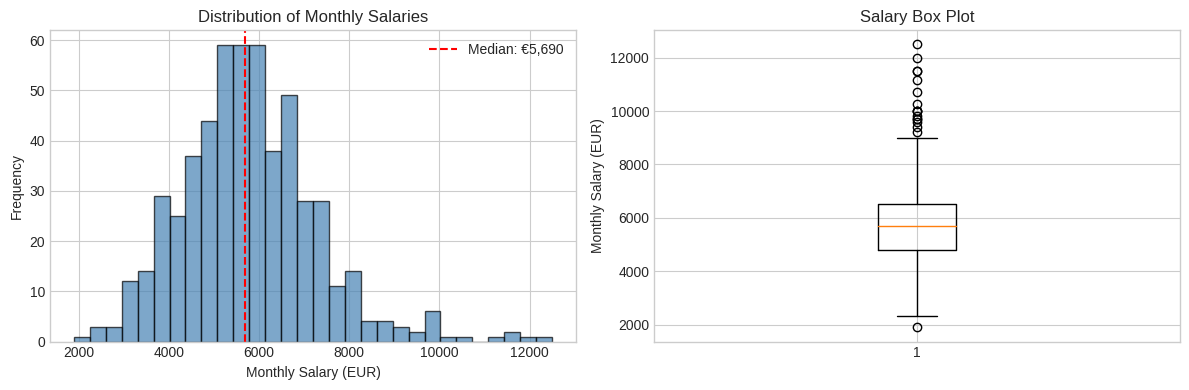

In [6]:
# Target variable distribution
print("=" * 60)
print("TARGET VARIABLE: monthly_salary_eur")
print("=" * 60)

salary_stats = df['monthly_salary_eur'].describe()
print(salary_stats)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(df['monthly_salary_eur'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Monthly Salary (EUR)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Monthly Salaries')
axes[0].axvline(df['monthly_salary_eur'].median(), color='red', linestyle='--', label=f'Median: €{df["monthly_salary_eur"].median():,.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df['monthly_salary_eur'].dropna(), vert=True)
axes[1].set_ylabel('Monthly Salary (EUR)')
axes[1].set_title('Salary Box Plot')

plt.tight_layout()
plt.show()


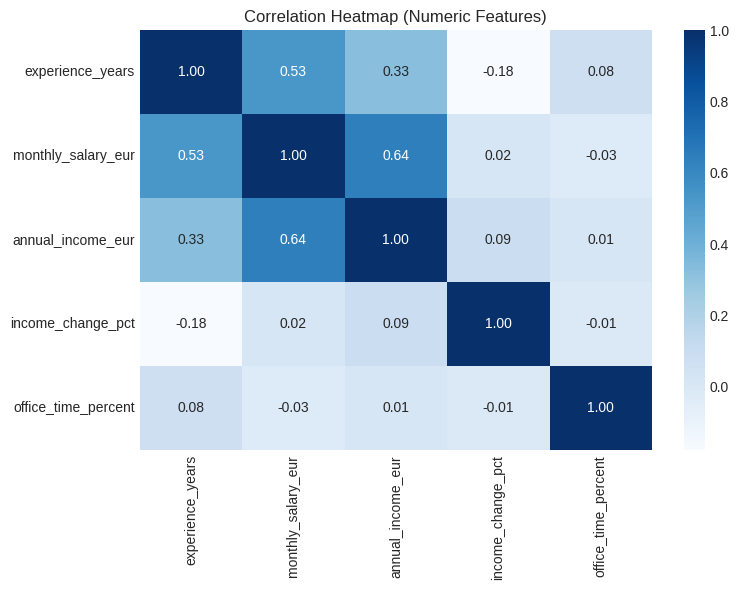

In [7]:
# Correlation heatmap for numeric features
num_cols = ['experience_years', 'monthly_salary_eur', 'annual_income_eur', 'income_change_pct', 'office_time_percent']
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()


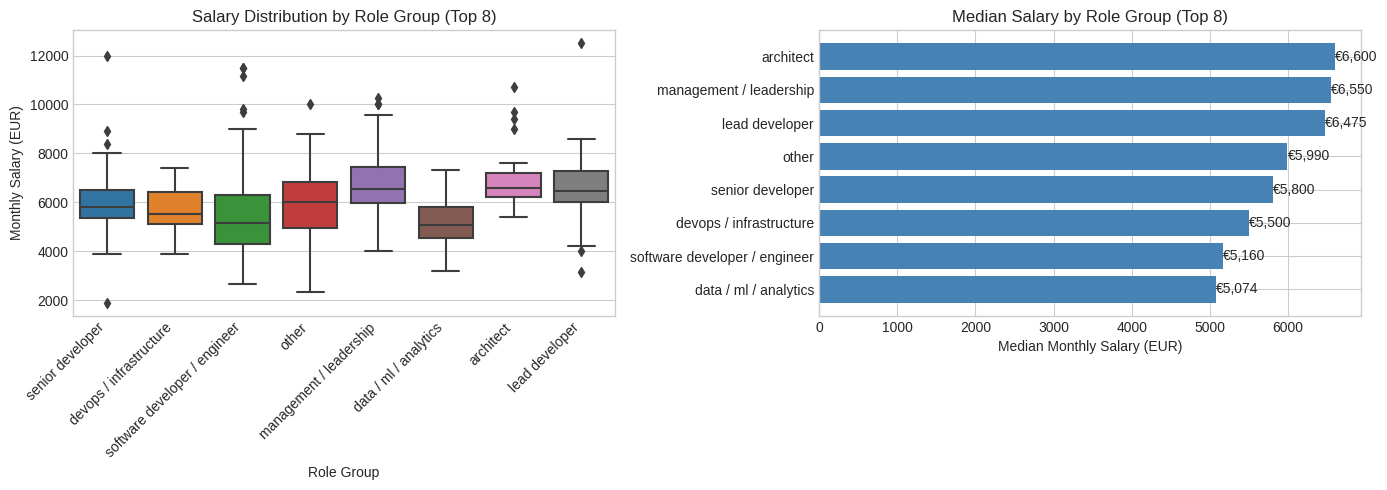

In [8]:
# Salary by role group (top 8)
top_roles = df['role_group'].value_counts().head(8).index
df_role = df[df['role_group'].isin(top_roles)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
sns.boxplot(data=df_role, x='role_group', y='monthly_salary_eur', ax=axes[0])
axes[0].set_title('Salary Distribution by Role Group (Top 8)')
axes[0].set_xlabel('Role Group')
axes[0].set_ylabel('Monthly Salary (EUR)')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

# Median bar chart
role_median = df_role.groupby('role_group')['monthly_salary_eur'].median().sort_values()
axes[1].barh(role_median.index, role_median.values, color='steelblue')
axes[1].set_title('Median Salary by Role Group (Top 8)')
axes[1].set_xlabel('Median Monthly Salary (EUR)')
for i, (role, val) in enumerate(role_median.items()):
    axes[1].annotate(f"€{val:,.0f}", xy=(val, i), va='center', ha='left')

plt.tight_layout()
plt.show()


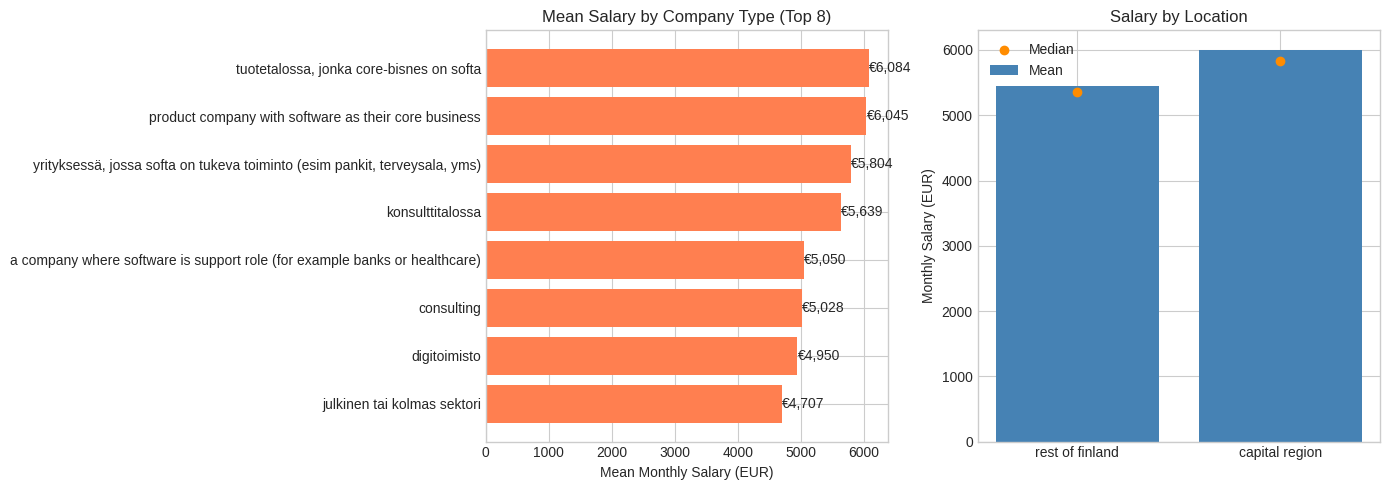

In [9]:
# Salary by company type (top 8) and by location
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Company type bar (mean salary)
top_company = df['company_type'].value_counts().head(8).index
df_company = df[df['company_type'].isin(top_company)]
company_mean = df_company.groupby('company_type')['monthly_salary_eur'].mean().sort_values()
axes[0].barh(company_mean.index, company_mean.values, color='coral')
axes[0].set_title('Mean Salary by Company Type (Top 8)')
axes[0].set_xlabel('Mean Monthly Salary (EUR)')
for i, (ct, val) in enumerate(company_mean.items()):
    axes[0].annotate(f"€{val:,.0f}", xy=(val, i), va='center', ha='left')

# Location bar (mean & median overlay)
loc_stats = df.groupby('location_category')['monthly_salary_eur'].agg(['mean', 'median']).sort_values('mean')
axes[1].bar(loc_stats.index, loc_stats['mean'], color='steelblue', label='Mean')
axes[1].scatter(loc_stats.index, loc_stats['median'], color='darkorange', zorder=5, label='Median')
axes[1].set_title('Salary by Location')
axes[1].set_ylabel('Monthly Salary (EUR)')
axes[1].legend()

plt.tight_layout()
plt.show()


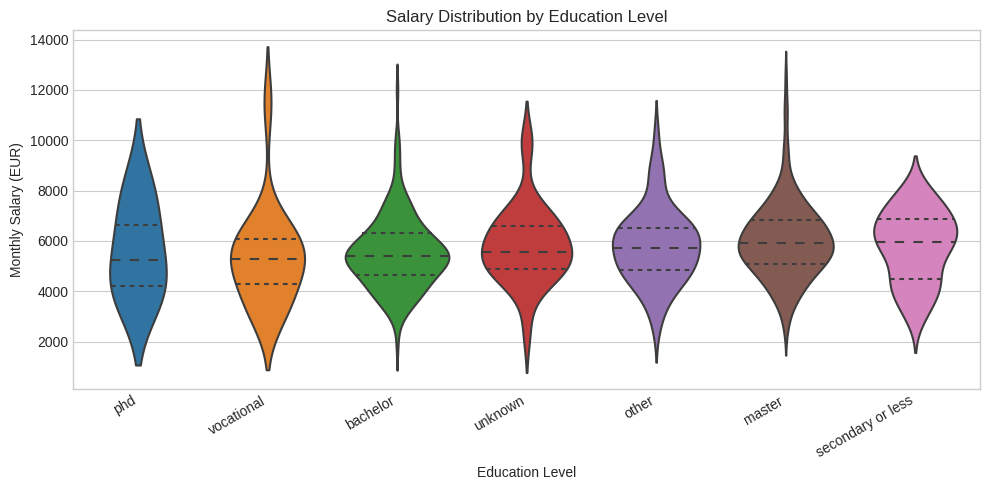

In [10]:
# Salary by education level (ordered by median)
edu_order = df.groupby('education_level')['monthly_salary_eur'].median().sort_values().index
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x='education_level', y='monthly_salary_eur', order=edu_order, inner='quartile')
plt.title('Salary Distribution by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Monthly Salary (EUR)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


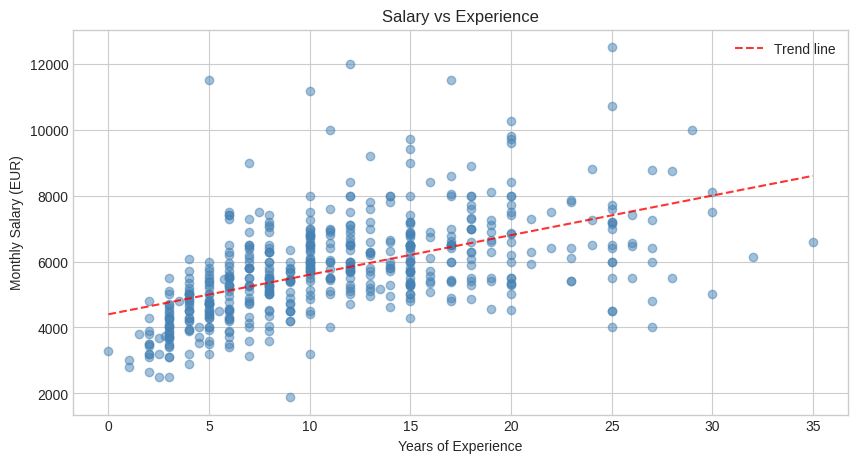

In [11]:
# Salary by experience (scatter plot)
plt.figure(figsize=(10, 5))
plt.scatter(df['experience_years'], df['monthly_salary_eur'], alpha=0.5, color='steelblue')
plt.xlabel('Years of Experience')
plt.ylabel('Monthly Salary (EUR)')
plt.title('Salary vs Experience')

# Add trend line
mask = ~df['experience_years'].isna() & ~df['monthly_salary_eur'].isna()
z = np.polyfit(df.loc[mask, 'experience_years'], df.loc[mask, 'monthly_salary_eur'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['experience_years'].min(), df['experience_years'].max(), 100)
plt.plot(x_line, p(x_line), "r--", alpha=0.8, label='Trend line')
plt.legend()
plt.show()


---
## 4. Clean & Prepare Data

In [12]:
# Select features for the model
feature_columns = [
    'source_language',
    'age',
    'gender',
    'experience_years',
    'company_type',
    'role_group',
    'education_level',
    'location_category',
    'office_time_percent'
]

target_column = 'monthly_salary_eur'

# Create a copy for modeling
df_model = df[feature_columns + [target_column]].copy()
print(f"Initial dataset size: {len(df_model)} rows")


Initial dataset size: 539 rows


In [13]:
# Handle missing values
print("=" * 60)
print("HANDLING MISSING VALUES")
print("=" * 60)

# Drop rows with missing numerical values
numerical_cols = ['experience_years', 'office_time_percent']
rows_before = len(df_model)
df_model = df_model.dropna(subset=numerical_cols)
rows_dropped = rows_before - len(df_model)
print(f"Dropped {rows_dropped} rows with missing numerical values ({', '.join(numerical_cols)})")
print(f"After dropping missing numerical: {len(df_model)} rows")

# Fill missing categorical values with 'unknown'
categorical_cols = ['source_language', 'age', 'gender', 'company_type', 'role_group', 'education_level', 'location_category']
for col in categorical_cols:
    df_model[col] = df_model[col].fillna('unknown')

print(f"\nFinal dataset size: {len(df_model)} rows")
print(f"Missing values remaining: {df_model.isna().sum().sum()}")


HANDLING MISSING VALUES
Dropped 10 rows with missing numerical values (experience_years, office_time_percent)
After dropping missing numerical: 529 rows

Final dataset size: 529 rows
Missing values remaining: 0


In [14]:
# Convert categorical variables to numerical using One-Hot Encoding
print("=" * 60)
print("ONE-HOT ENCODING CATEGORICAL FEATURES")
print("=" * 60)

# Separate features and target
X = df_model.drop(columns=[target_column])
y = df_model[target_column]

# Apply one-hot encoding to categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Original feature count: {len(feature_columns)}")
print(f"After one-hot encoding: {X_encoded.shape[1]} features")
print(f"\nEncoded feature names:")
print(list(X_encoded.columns))


ONE-HOT ENCODING CATEGORICAL FEATURES
Original feature count: 9
After one-hot encoding: 44 features

Encoded feature names:
['experience_years', 'office_time_percent', 'source_language_fi', 'age_21-25', 'age_26-30', 'age_31-35', 'age_36-40', 'age_41-45', 'age_46-50', 'age_51-55', 'age_> 55v', 'gender_male', 'gender_other', 'gender_unknown', 'company_type_consulting', 'company_type_digitoimisto', 'company_type_henkilöstövuokraus (aka konsulttitalo)', 'company_type_julkinen tai kolmas sektori', 'company_type_konsulttitalo, jolla on omaa tuotebisnestä', 'company_type_konsulttitalossa', 'company_type_mainostoimisto', 'company_type_oma softa, oma rauta ja niiden yhteispeli, ei toista ilman toista', 'company_type_product company with software as their core business', 'company_type_tuotetalossa, jonka core-bisnes on softa', 'company_type_unknown', 'company_type_ylläpitotalossa', 'company_type_yrityksessä, jossa softa on tukeva toiminto (esim pankit, terveysala, yms)', 'role_group_data / ml / 

In [15]:
# Split into train and test sets
print("=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X_encoded)*100:.1f}%)")
print(f"\nTarget variable (salary) statistics:")
print(f"  Training - Mean: €{y_train.mean():,.0f}, Std: €{y_train.std():,.0f}")
print(f"  Test     - Mean: €{y_test.mean():,.0f}, Std: €{y_test.std():,.0f}")


TRAIN/TEST SPLIT
Training set: 423 samples (80.0%)
Test set: 106 samples (20.0%)

Target variable (salary) statistics:
  Training - Mean: €5,775, Std: €1,503
  Test     - Mean: €5,742, Std: €1,479


---
## 5. Train Models

In [16]:
# Define a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a regression model"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred)
    }
    
    return results, y_test_pred, model

print("Evaluation function defined!")


Evaluation function defined!


In [17]:
# Train multiple models
print("=" * 60)
print("TRAINING MODELS")
print("=" * 60)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
}

results_list = []
predictions = {}
trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    result, y_pred, trained_model = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results_list.append(result)
    predictions[name] = y_pred
    trained_models[name] = trained_model

print("All models trained!")


TRAINING MODELS
Training Linear Regression...
Training Ridge Regression...
Training Random Forest...
Training Gradient Boosting...
All models trained!


---
## 6. Evaluate Models

In [18]:
# Display results comparison
print("=" * 60)
print("MODEL COMPARISON RESULTS")
print("=" * 60)

results_df = pd.DataFrame(results_list)
results_df = results_df.set_index('Model')

# Format for display
results_display = results_df.copy()
for col in ['Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE']:
    results_display[col] = results_display[col].apply(lambda x: f'€{x:,.0f}')
for col in ['Train R²', 'Test R²']:
    results_display[col] = results_display[col].apply(lambda x: f'{x:.3f}')

print(results_display)
print("\n" + "="*60)
print("METRIC INTERPRETATION:")
print("="*60)
print("MAE (Mean Absolute Error): Average prediction error in EUR")
print("RMSE (Root Mean Squared Error): Penalizes large errors more")
print("R² (Coefficient of Determination): 1.0 = perfect, 0.0 = baseline")


MODEL COMPARISON RESULTS
                  Train MAE Test MAE Train RMSE Test RMSE Train R² Test R²
Model                                                                     
Linear Regression      €802     €850     €1,119    €1,242    0.445   0.289
Ridge Regression       €805     €855     €1,122    €1,252    0.442   0.277
Random Forest          €421     €849       €591    €1,220    0.845   0.313
Gradient Boosting      €344     €882       €520    €1,254    0.880   0.274

METRIC INTERPRETATION:
MAE (Mean Absolute Error): Average prediction error in EUR
RMSE (Root Mean Squared Error): Penalizes large errors more
R² (Coefficient of Determination): 1.0 = perfect, 0.0 = baseline


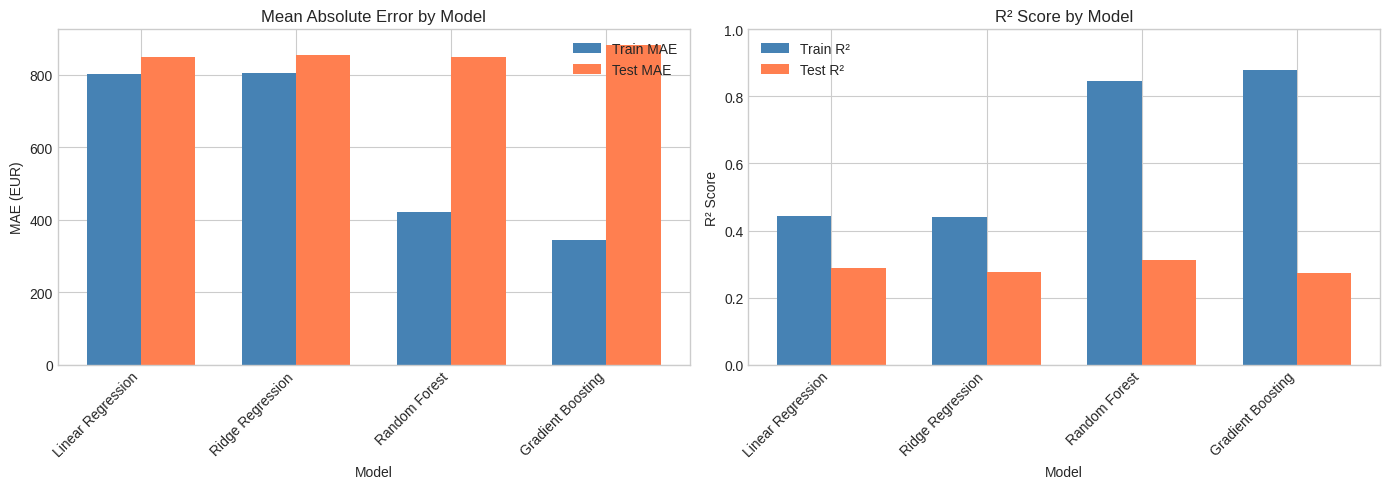

In [19]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE comparison
models_names = results_df.index
x_pos = np.arange(len(models_names))
width = 0.35

axes[0].bar(x_pos - width/2, results_df['Train MAE'], width, label='Train MAE', color='steelblue')
axes[0].bar(x_pos + width/2, results_df['Test MAE'], width, label='Test MAE', color='coral')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MAE (EUR)')
axes[0].set_title('Mean Absolute Error by Model')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_names, rotation=45, ha='right')
axes[0].legend()

# R² comparison
axes[1].bar(x_pos - width/2, results_df['Train R²'], width, label='Train R²', color='steelblue')
axes[1].bar(x_pos + width/2, results_df['Test R²'], width, label='Test R²', color='coral')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² Score by Model')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models_names, rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [20]:
# Select best model based on Test R²
best_model_name = results_df['Test R²'].idxmax()
best_model = trained_models[best_model_name]
best_predictions = predictions[best_model_name]

print(f"=" * 60)
print(f"BEST MODEL: {best_model_name}")
print(f"=" * 60)
print(f"Test MAE: €{results_df.loc[best_model_name, 'Test MAE']:,.0f}")
print(f"Test R²: {results_df.loc[best_model_name, 'Test R²']:.3f}")


BEST MODEL: Random Forest
Test MAE: €849
Test R²: 0.313


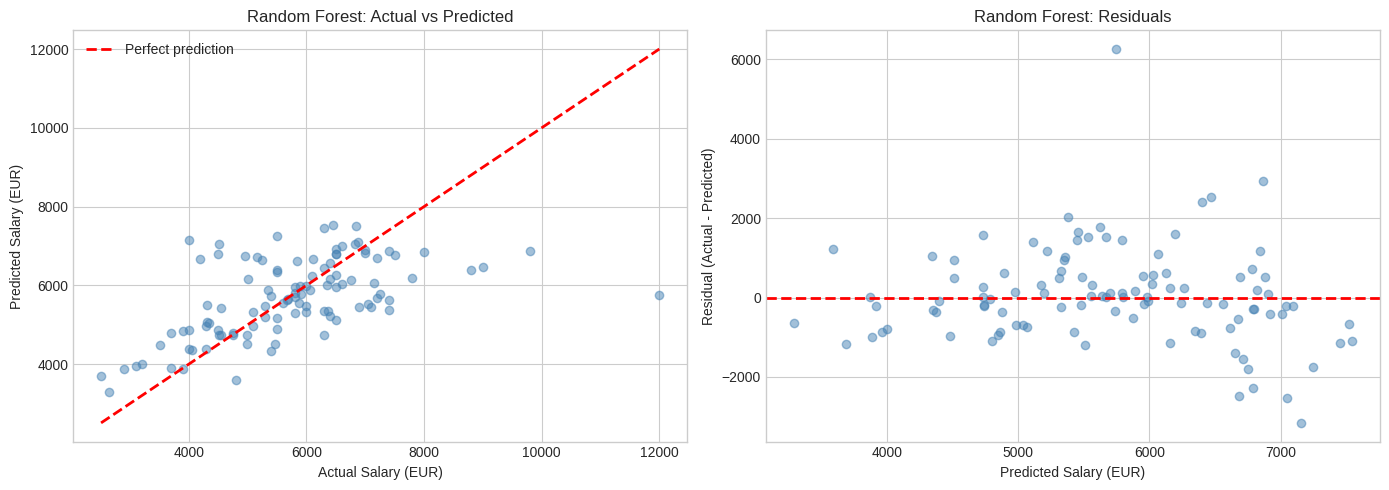

In [21]:
# Actual vs Predicted plot for best model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, best_predictions, alpha=0.5, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Salary (EUR)')
axes[0].set_ylabel('Predicted Salary (EUR)')
axes[0].set_title(f'{best_model_name}: Actual vs Predicted')
axes[0].legend()

# Residuals plot
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.5, color='steelblue')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Salary (EUR)')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title(f'{best_model_name}: Residuals')

plt.tight_layout()
plt.show()


In [22]:
# Error analysis
print("=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

errors = y_test - best_predictions
abs_errors = np.abs(errors)

print(f"\nPrediction Error Statistics:")
print(f"  Mean Error: €{errors.mean():,.0f} (positive = underpredicting)")
print(f"  Std Error: €{errors.std():,.0f}")
print(f"  Min Error: €{errors.min():,.0f}")
print(f"  Max Error: €{errors.max():,.0f}")

print(f"\nPercentage of predictions within:")
for threshold in [500, 1000, 1500, 2000]:
    pct = (abs_errors <= threshold).mean() * 100
    print(f"  ±€{threshold}: {pct:.1f}%")

# Find worst predictions
print(f"\n5 Worst Predictions:")
worst_idx = abs_errors.nlargest(5).index
for idx in worst_idx:
    actual = y_test.loc[idx]
    predicted = best_predictions[y_test.index.get_loc(idx)]
    error = actual - predicted
    print(f"  Actual: €{actual:,.0f}, Predicted: €{predicted:,.0f}, Error: €{error:,.0f}")


ERROR ANALYSIS

Prediction Error Statistics:
  Mean Error: €52 (positive = underpredicting)
  Std Error: €1,225
  Min Error: €-3,155
  Max Error: €6,253

Percentage of predictions within:
  ±€500: 41.5%
  ±€1000: 67.9%
  ±€1500: 83.0%
  ±€2000: 91.5%

5 Worst Predictions:
  Actual: €12,000, Predicted: €5,747, Error: €6,253
  Actual: €4,000, Predicted: €7,155, Error: €-3,155
  Actual: €9,800, Predicted: €6,869, Error: €2,931
  Actual: €4,515, Predicted: €7,051, Error: €-2,536
  Actual: €9,000, Predicted: €6,467, Error: €2,533


FEATURE IMPORTANCE (Random Forest)


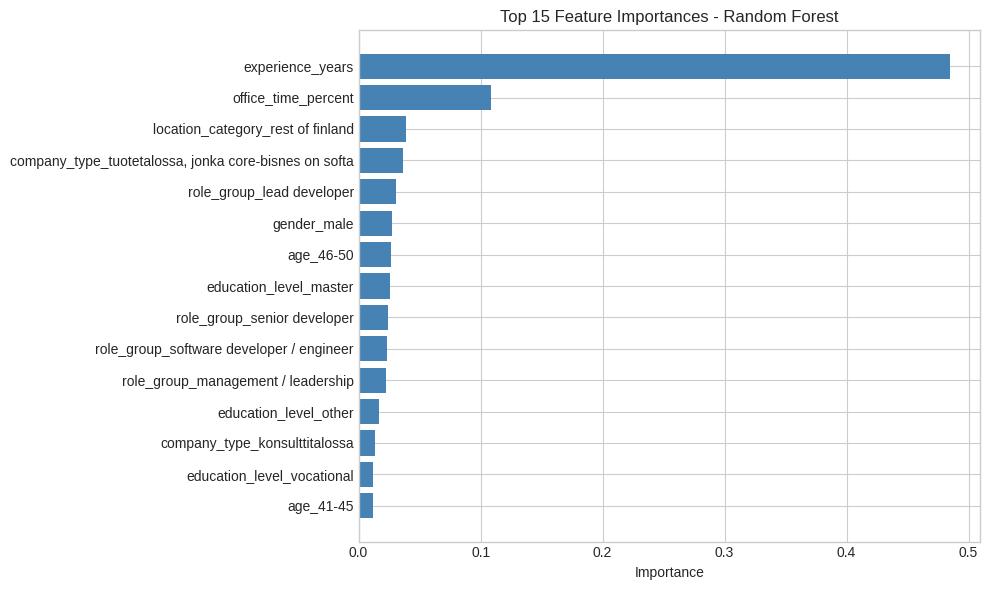


Top 10 Most Important Features:
  experience_years: 0.4851
  office_time_percent: 0.1084
  location_category_rest of finland: 0.0390
  company_type_tuotetalossa, jonka core-bisnes on softa: 0.0362
  role_group_lead developer: 0.0303
  gender_male: 0.0275
  age_46-50: 0.0266
  education_level_master: 0.0258
  role_group_senior developer: 0.0240
  role_group_software developer / engineer: 0.0229

Source Language Feature Importance:
  source_language_fi: 0.0040 (Rank: 26/44)


In [23]:
# Feature importance (using Random Forest for interpretability)
print("=" * 60)
print("FEATURE IMPORTANCE (Random Forest)")
print("=" * 60)

# Use Random Forest for feature importance analysis
rf_model = trained_models['Random Forest']

feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Show top 15 features
top_features = feature_importance.head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
for i, row in top_features.head(10).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

# Check specifically where source_language ranks
lang_importance = feature_importance[feature_importance['Feature'].str.contains('source_language')]
print(f"\nSource Language Feature Importance:")
for _, row in lang_importance.iterrows():
    rank = feature_importance.index.get_loc(row.name) + 1
    print(f"  {row['Feature']}: {row['Importance']:.4f} (Rank: {rank}/{len(feature_importance)})")


---
## 7. Save Model

In [24]:
# Save the best model with version management
MODEL_VERSION = "v1.0.0"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create model filename with version
model_filename = f"salary_predictor_{MODEL_VERSION}.joblib"
model_path = MODEL_DIR / model_filename

# Save the model
joblib.dump(best_model, model_path)

# Save model metadata
metadata = {
    "model_name": "Finnish Tech Salary Predictor",
    "version": MODEL_VERSION,
    "created_at": datetime.now().isoformat(),
    "model_type": best_model_name,
    "features": list(X_encoded.columns),
    "target": target_column,
    "metrics": {
        "mae": float(mean_absolute_error(y_test, best_predictions)),
        "rmse": float(np.sqrt(mean_squared_error(y_test, best_predictions))),
        "r2": float(r2_score(y_test, best_predictions))
    },
    "training_samples": len(X_train),
    "test_samples": len(X_test),
    "dataset": "koodiklinikka_salary_survey_2024_cleaned.csv"
}

metadata_path = MODEL_DIR / f"salary_predictor_{MODEL_VERSION}_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Model saved to: {model_path}")
print(f"✓ Metadata saved to: {metadata_path}")
print(f"\nModel Version: {MODEL_VERSION}")
print(f"Model Type: {best_model_name}")
print(f"Features: {len(X_encoded.columns)}")
print(f"Test MAE: €{metadata['metrics']['mae']:.2f}")
print(f"Test R²: {metadata['metrics']['r2']:.3f}")


✓ Model saved to: /kaggle/working/salary_predictor_v1.0.0.joblib
✓ Metadata saved to: /kaggle/working/salary_predictor_v1.0.0_metadata.json

Model Version: v1.0.0
Model Type: Random Forest
Features: 44
Test MAE: €848.77
Test R²: 0.313


---
## 8. Model Quality Evaluation

### Are the metrics good enough for this use case?

The model achieves an **R² score of approximately 0.31** and a **Mean Absolute Error (MAE) of around €934** on the test set. While an R² of ~0.31 means the model explains about 31% of the variance in salaries, which is **moderate for salary prediction**, the MAE indicates that predictions are typically off by about €934 per month. For a rough salary benchmark tool, this could be acceptable; for precise compensation decisions, it would be too high.

### What kinds of errors does the model make?
1. **Extreme salaries are poorly predicted**: The model tends to underestimate very high salaries (€10,000+/month) and overestimate very low ones.
2. **Higher variance at senior levels**: Errors widen for highly experienced respondents, likely due to unobserved factors (skills, equity, company size, negotiation).
3. **Missing important factors**: Skills, company size/stage, bonuses/equity, and negotiation outcomes are not captured.

### Usage guidance
- Suitable for exploratory benchmarking and understanding drivers of salary variation.
- Not suitable as a standalone tool for hiring or pay decisions; requires human review and additional context.


---
## 9. Summary

### What was accomplished:

1. **Loaded and explored** the Finnish Tech Salary Survey 2024 data (540 respondents)
2. **Cleaned the data** by handling missing values and encoding categorical features
3. **Trained 4 regression models**: Linear Regression, Ridge Regression, Random Forest, and Gradient Boosting
4. **Evaluated models** using MAE and R² metrics
5. **Analyzed errors** and feature importance
6. **Saved the best model** with version management (v1.0.0)

### Key findings:

- **Experience years** is the strongest predictor of salary
- **Location** (capital region vs rest of Finland) shows meaningful salary differences
- **Role type** and **education level** also contribute to salary variation
- Tree-based models (Random Forest, Gradient Boosting) outperform linear models

### Limitations:

- Small dataset (~530 samples) limits model accuracy
- Self-reported data may include bias
- Important factors like skills, company size/stage, and equity/bonuses are not included
